In [6]:
import sys
src_path = '..\\src'
src_path_2 = '..\\venv\\Lib\\site-packages'


if src_path not in sys.path:
        sys.path.insert(0, src_path)

if src_path_2 not in sys.path:
        sys.path.insert(0, src_path_2)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.express as px
import seaborn as sns

from pandasql import sqldf
from sklearn.metrics import mean_squared_error

# Alle funskjonene ligger i en felles fil
import functions as fc

# Forberedelser
### Last ned datasettet

In [7]:
# Hente frem datasettet og kaller det wind
try: 
    wind = pd.read_csv('../data/wind.csv')
except FileNotFoundError:
    print('Fila finnes ikke')

# Dobbelskjekket at dataen har kommet
wind.head()

,verdi,tidsforskyvning,referansetid
0,6.9,PT0H,2024-01-01T00:00:00.000Z
1,6.3,PT0H,2024-01-02T00:00:00.000Z
2,5.4,PT0H,2024-01-03T00:00:00.000Z
3,4.8,PT0H,2024-01-04T00:00:00.000Z
4,1.9,PT0H,2024-01-05T00:00:00.000Z


Datasettet er lastet ned og vi vet at den har kommet, på grunn av at vi kan se de første 5 linjene.

# Forstå data
Se hvilke datatyper vi har og blir mere kjent med datasettet, for å gjøre det lettere å jobbe med.

In [8]:
# Skjekker hvilke datatype refaransetid er
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   verdi            732 non-null    float64
 1   tidsforskyvning  732 non-null    object 
 2   referansetid     732 non-null    object 
dtypes: float64(1), object(2)
memory usage: 17.3+ KB


I dette datasettet har vi integer, float og object som vi vet er string.

In [9]:
# Forstå dataen
print('type:', type(wind))
print('shape:', wind.shape)

type: <class 'pandas.core.frame.DataFrame'>
shape: (732, 3)


### Verdier

In [10]:
# Den minste og største verdien
print('Den minste verdien er', wind['verdi'].min())
print('Den største verdien er', wind['verdi'].max())

Den minste verdien er 0.6
Den største verdien er 11.4


In [11]:
# 10 tilfelige verdier
wind.sample(10)

,verdi,tidsforskyvning,referansetid
532,2.3,PT0H,2024-06-15T00:00:00.000Z
216,1.5,PT0H,2024-08-04T00:00:00.000Z
217,2.1,PT0H,2024-08-05T00:00:00.000Z
659,3.0,PT0H,2024-10-20T00:00:00.000Z
29,0.9,PT0H,2024-01-30T00:00:00.000Z
331,4.0,PT0H,2024-11-27T00:00:00.000Z
349,2.1,PT0H,2024-12-15T00:00:00.000Z
512,3.0,PT0H,2024-05-26T00:00:00.000Z
388,3.0,PT0H,2024-01-23T00:00:00.000Z
653,5.0,PT0H,2024-10-14T00:00:00.000Z


In [12]:
# De siste verdiene
wind.tail()

,verdi,tidsforskyvning,referansetid
727,4.3,PT0H,2024-12-27T00:00:00.000Z
728,6.2,PT0H,2024-12-28T00:00:00.000Z
729,6.2,PT0H,2024-12-29T00:00:00.000Z
730,6.1,PT0H,2024-12-30T00:00:00.000Z
731,4.4,PT0H,2024-12-31T00:00:00.000Z


# Manglende verdier

I denne delen skal vi se om datasettet mangler noen verdier.

verdi              0
tidsforskyvning    0
referansetid       0
dtype: int64


Empty DataFrame
Columns: [verdi, tidsforskyvning, referansetid]
Index: []


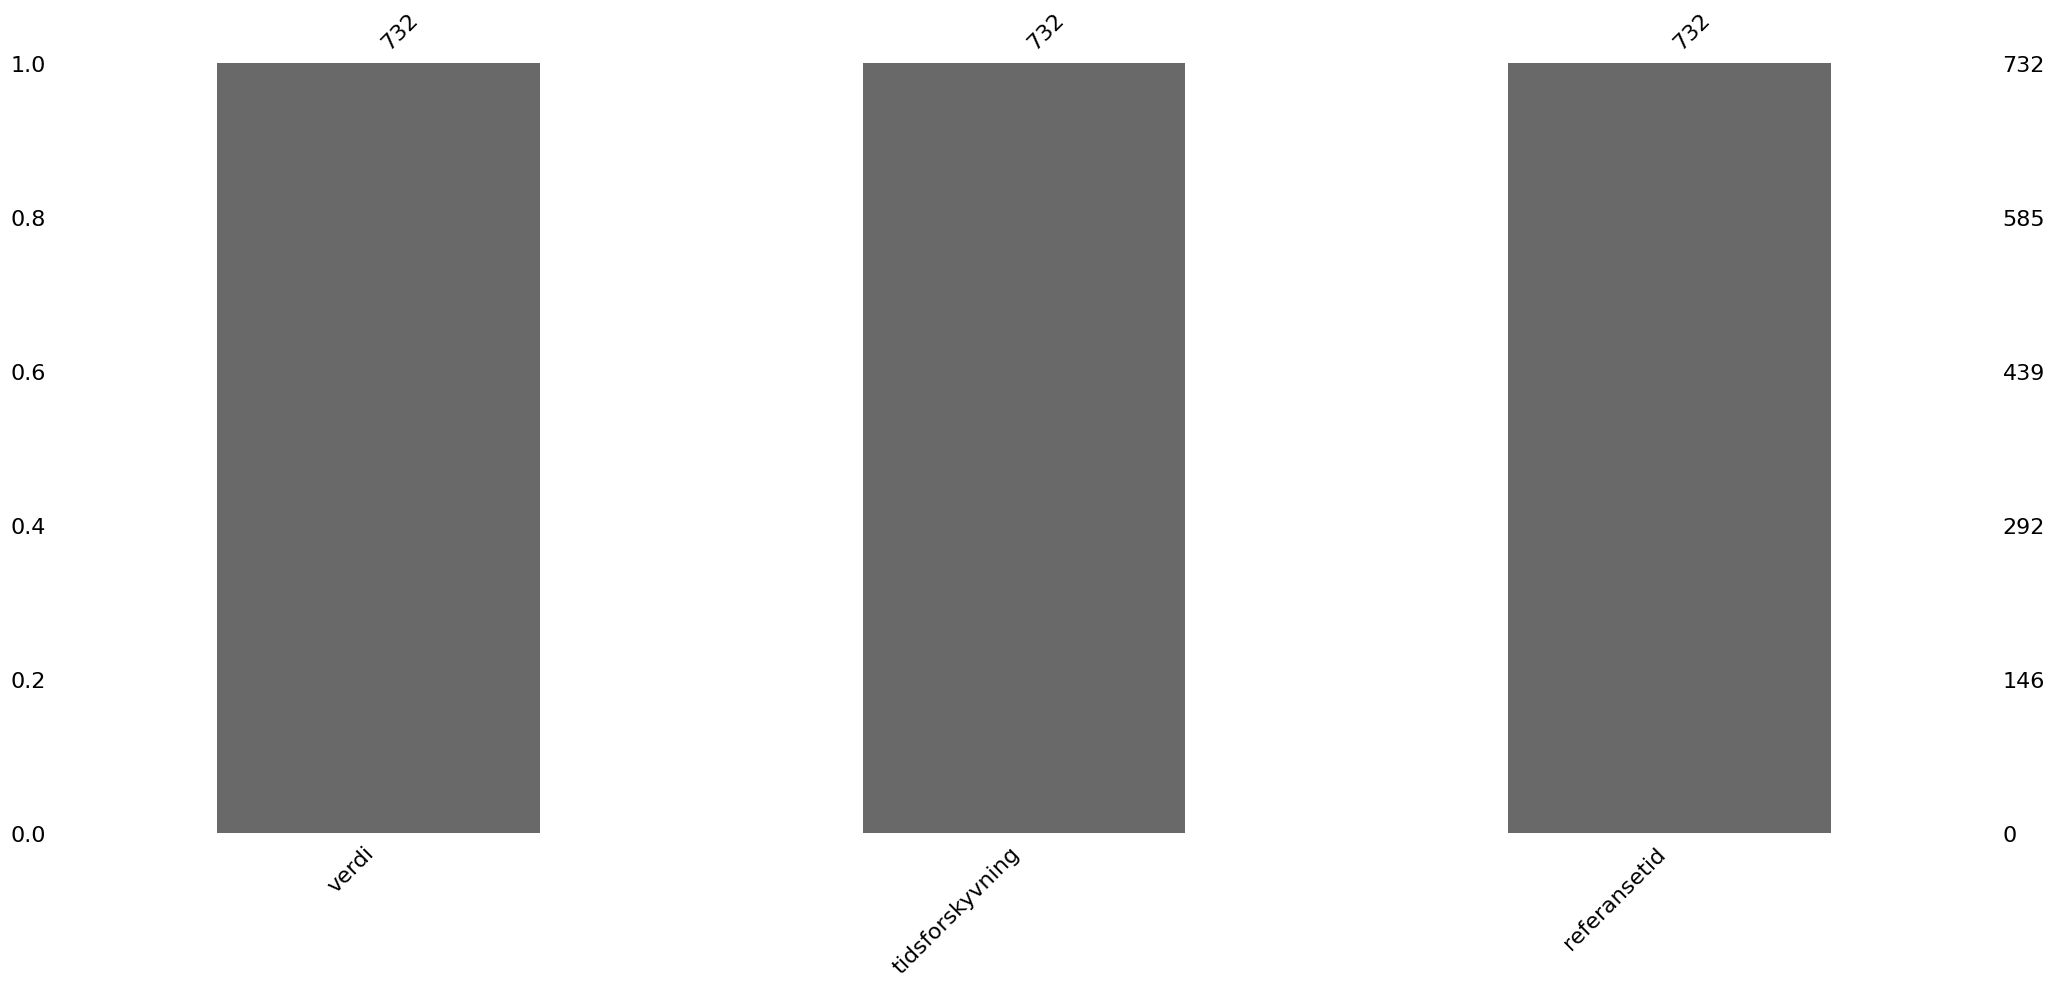

In [13]:
# Se om det mangler noen tall i dataen
fc.missing_numbers(wind)

I dette datasettet er det ingen verdier som mangler.

In [14]:
# Gjøre referansetid om til DateTime
wind['referansetid'] = pd.to_datetime(wind['referansetid'])

### Ekstreme verdier

Ekstreme verdier kan påvirke datasettet når det skal trenes opp til å gi en prognose om været senere, derfor kan det være lurt å fjerne de ekstreme verdiene.

Gjennomsnittlig verdi for datasettet er 3.04
Standardavviket er 1.61
     verdi tidsforskyvning              referansetid
392    8.2            PT0H 2024-01-27 00:00:00+00:00
394   11.1            PT0H 2024-01-29 00:00:00+00:00
395    9.1            PT0H 2024-01-30 00:00:00+00:00
410    9.0            PT0H 2024-02-14 00:00:00+00:00
411    8.1            PT0H 2024-02-15 00:00:00+00:00
420   11.4            PT0H 2024-02-24 00:00:00+00:00
423    8.6            PT0H 2024-02-27 00:00:00+00:00
424   10.3            PT0H 2024-02-28 00:00:00+00:00
425    8.5            PT0H 2024-02-29 00:00:00+00:00
426    9.5            PT0H 2024-03-01 00:00:00+00:00
651    8.7            PT0H 2024-10-12 00:00:00+00:00
652    8.0            PT0H 2024-10-13 00:00:00+00:00
664    8.5            PT0H 2024-10-25 00:00:00+00:00
698    7.9            PT0H 2024-11-28 00:00:00+00:00
725    8.4            PT0H 2024-12-25 00:00:00+00:00


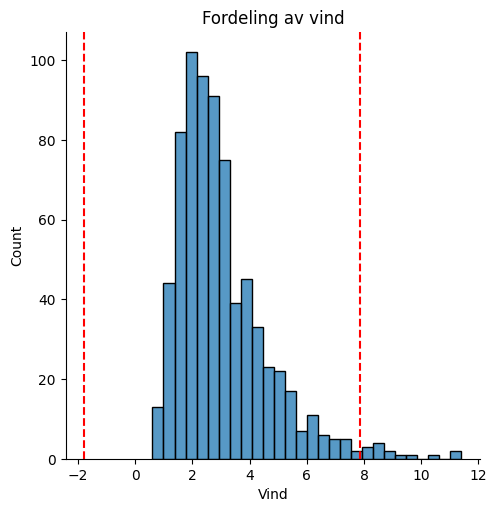

In [15]:
# Nedre og øvre grense av datasettet med standardavik
lower_limit, upper_limit = fc.lower_upper_limit(wind)

# Print verdiene som ikke er mellom lower_limit og upper_limit
outliers = wind[wind['verdi'].between(lower_limit, upper_limit) == False]
print(outliers)

# Lag et søylediagram med linjer som viser lower_limit og upper_limit
plot = sns.displot(data=wind['verdi']).set(title='Fordeling av vind', xlabel='Vind')
for ax in plot.axes.flat:
    ax.axvline(lower_limit, color='r', linestyle = '--', label='Lower Limit')
    ax.axvline(upper_limit, color='r', linestyle = '--', label='Upper Limit')

Innenfor linjene er det 99% av datasettet, dette er verdiene som ikke regnes som ekstreme. 

In [16]:
date = fc.make_datetime(wind)

referansetid er gjort om til DateTime


[8.2, 11.1, 9.1, 9.0, 8.1, 11.4, 8.6, 10.3, 8.5, 9.5, 8.7, 8.0, 8.5, 7.9, 8.4]
Den minste verdien er: 0.6
Den høyeste verdien er: 7.6


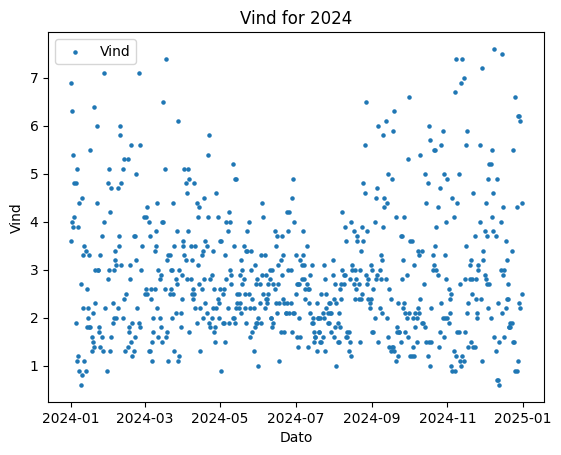

In [17]:
# Lag en liste
remove = []
# Putt verdiene utenfor linjene i listen
for i in outliers['verdi']:
    remove.append(i)
print(remove)


wind['verdi'] = wind['verdi'].replace(remove, np.nan)

# Print den minste og høyeste verdien etter at de ekstreme verdiene har blitt fjernet
print('Den minste verdien er:', wind['verdi'].min())
print('Den høyeste verdien er:', wind['verdi'].max())

# Lag en diagram med de nye veridene
plt.scatter(date, wind['verdi'], label='Vind', s=5)
plt.xlabel('Dato')
plt.ylabel('Vind')
plt.title('Vind for 2024')
plt.legend()
plt.show()

I dette nye diagrammet er det ingen verdier under 0,6 og ingen over 7,6. 

verdi              15
tidsforskyvning     0
referansetid        0
dtype: int64
     verdi tidsforskyvning              referansetid
392    NaN            PT0H 2024-01-27 00:00:00+00:00
394    NaN            PT0H 2024-01-29 00:00:00+00:00
395    NaN            PT0H 2024-01-30 00:00:00+00:00
410    NaN            PT0H 2024-02-14 00:00:00+00:00
411    NaN            PT0H 2024-02-15 00:00:00+00:00
420    NaN            PT0H 2024-02-24 00:00:00+00:00
423    NaN            PT0H 2024-02-27 00:00:00+00:00
424    NaN            PT0H 2024-02-28 00:00:00+00:00
425    NaN            PT0H 2024-02-29 00:00:00+00:00
426    NaN            PT0H 2024-03-01 00:00:00+00:00
651    NaN            PT0H 2024-10-12 00:00:00+00:00
652    NaN            PT0H 2024-10-13 00:00:00+00:00
664    NaN            PT0H 2024-10-25 00:00:00+00:00
698    NaN            PT0H 2024-11-28 00:00:00+00:00
725    NaN            PT0H 2024-12-25 00:00:00+00:00


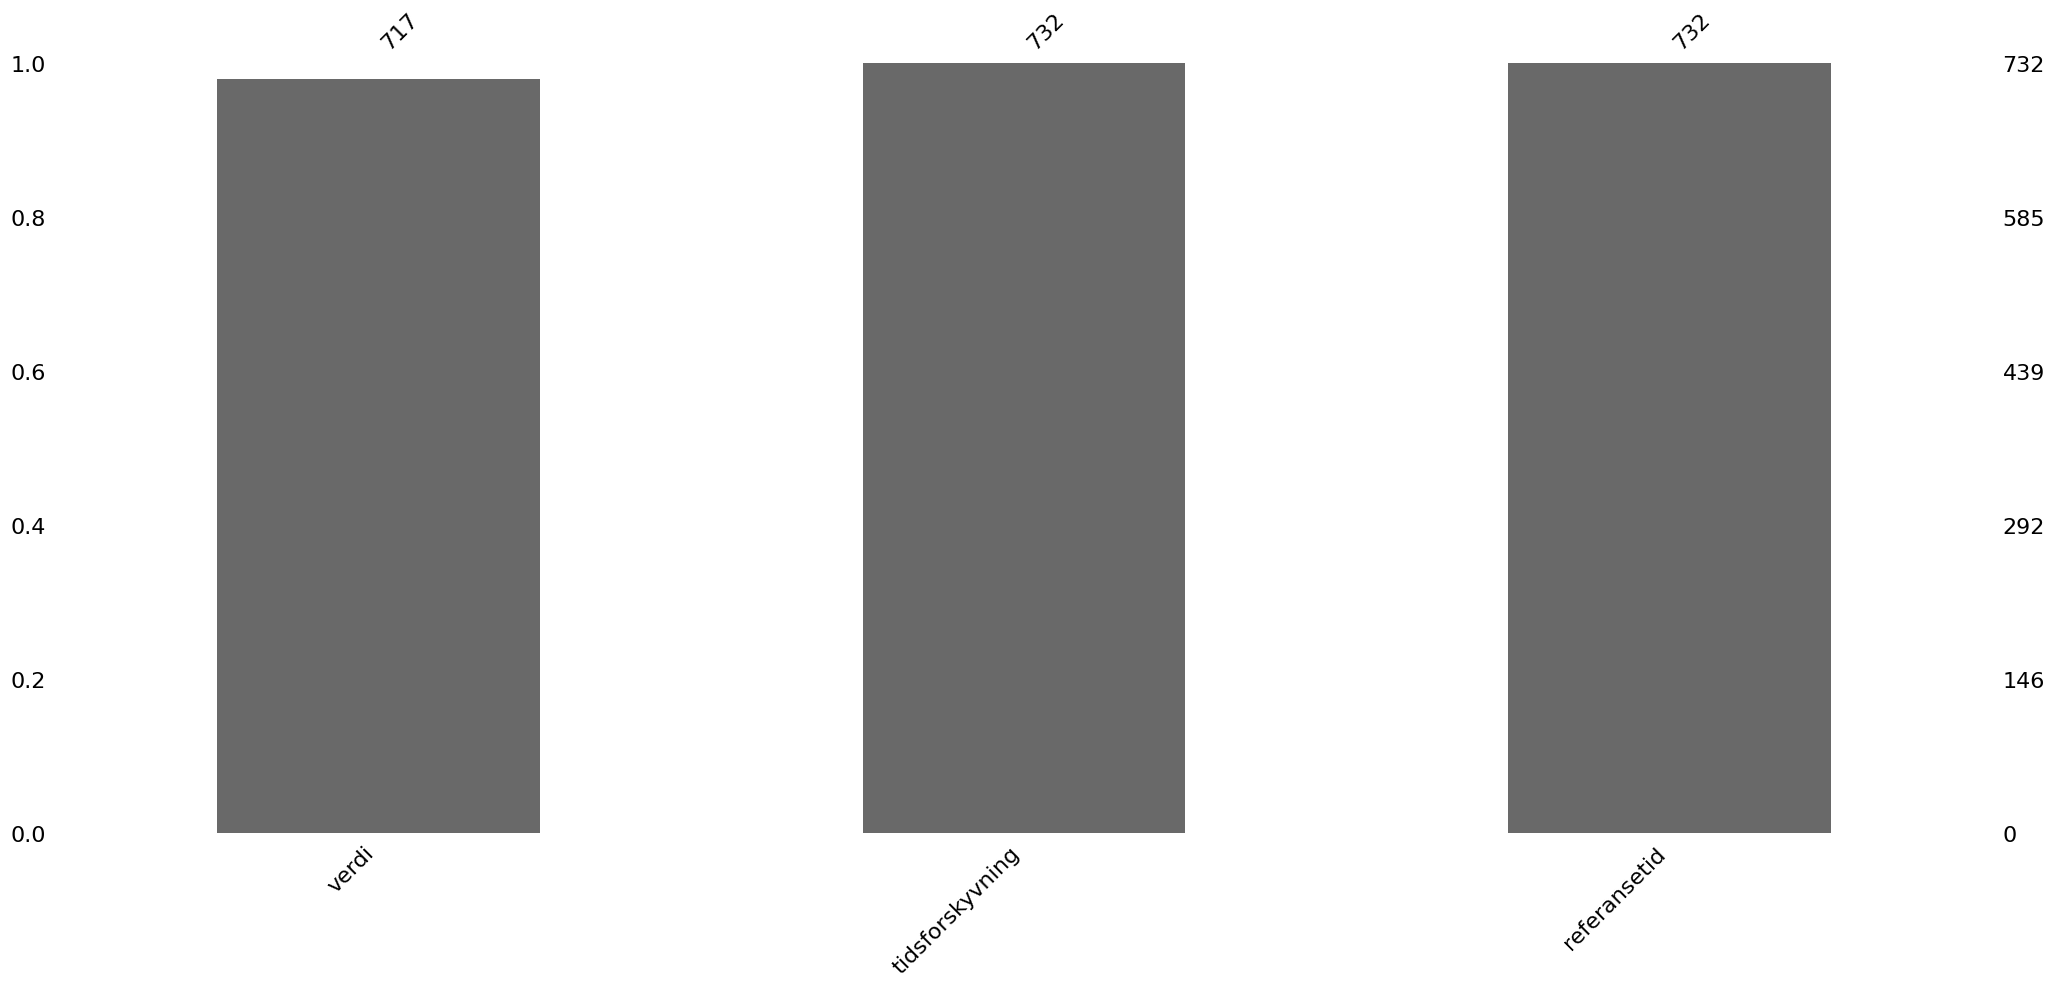

In [18]:
# Skjekker om det mangler verdier
fc.missing_numbers(wind)

Siden de ekstreme verdiene ble fjernet mangler det nå 15 verdier i datasettet. For at datasettet skal ha verdier på alle dagene må verdiene fylles.

C:\Users\sofie\AppData\Local\Temp\ipykernel_13932\1731849347.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  add_data = wind['verdi'].fillna(method='ffill', inplace=True)
C:\Users\sofie\AppData\Local\Temp\ipykernel_13932\1731849347.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  add_data = wind['verdi'].fillna(method='ffill', inplace=True)


verdi              0
tidsforskyvning    0
referansetid       0
dtype: int64
Empty DataFrame
Columns: [verdi, tidsforskyvning, referansetid]
Index: []


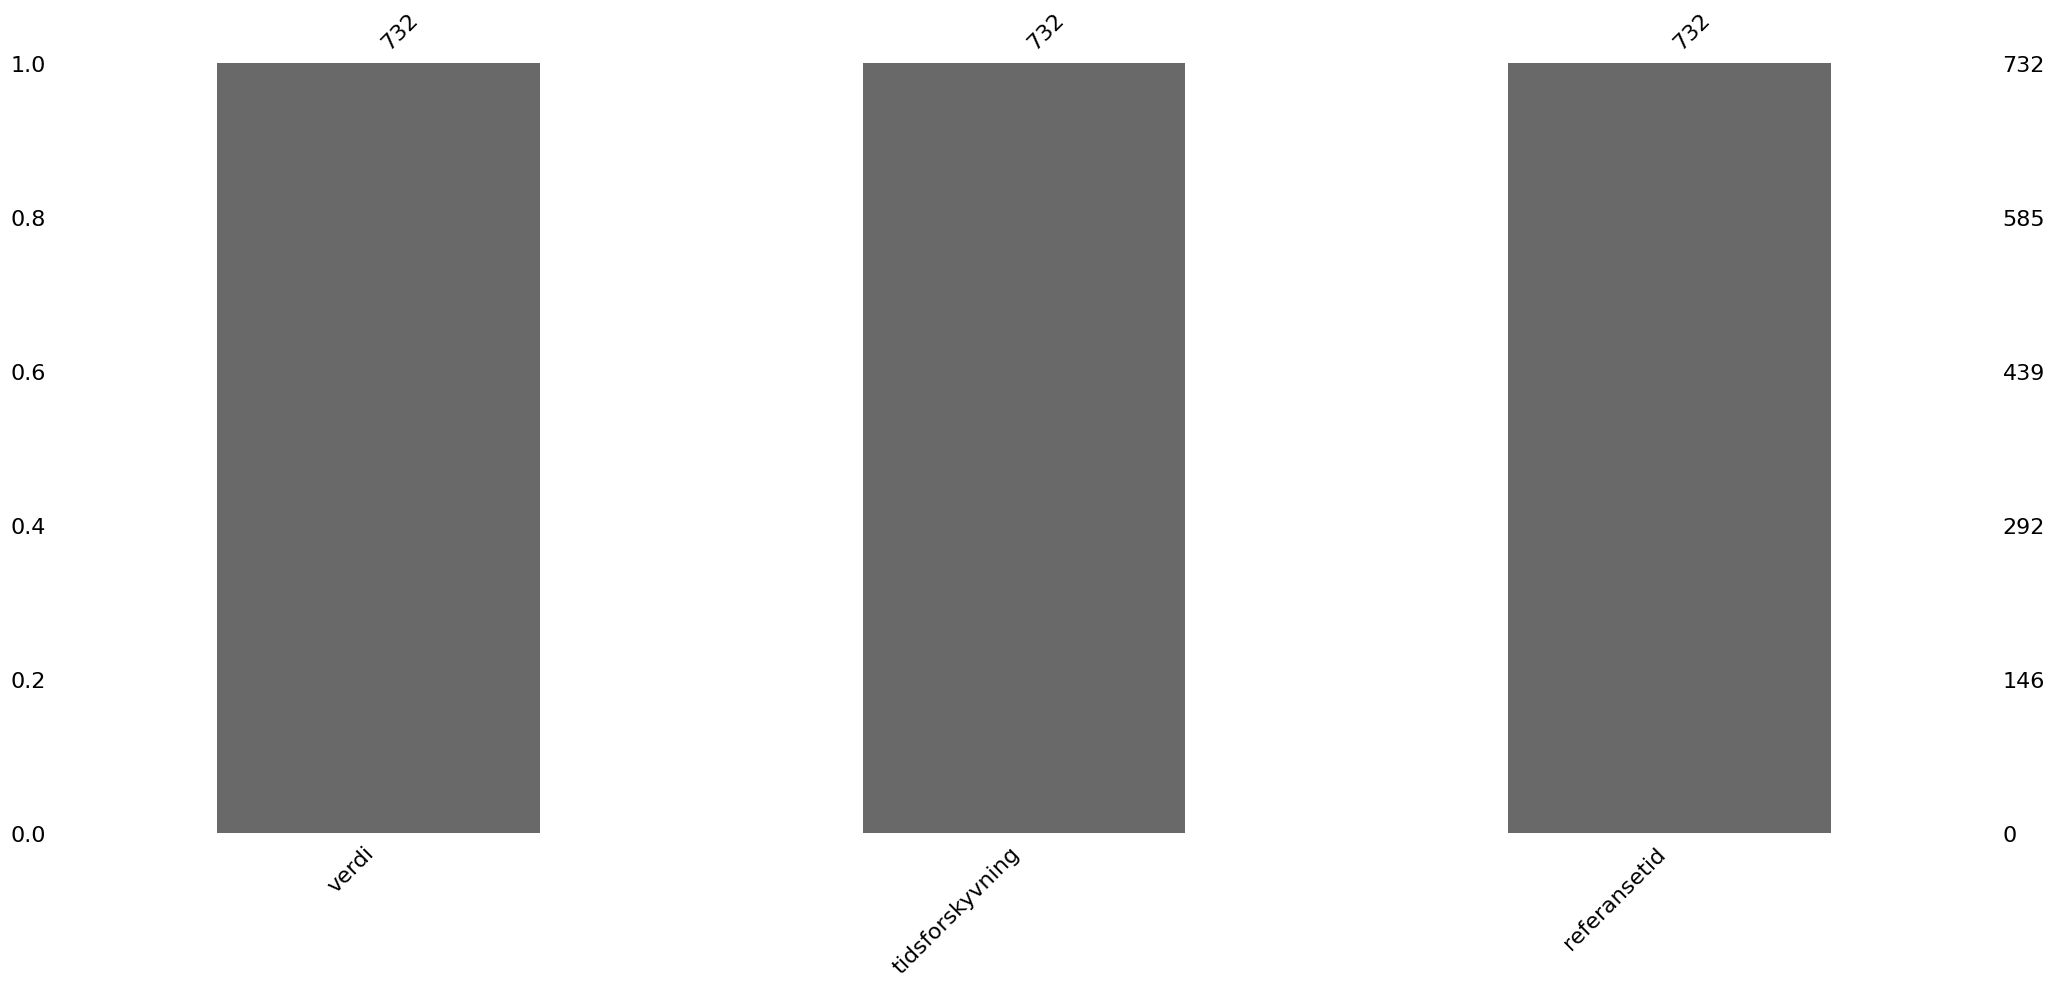

In [19]:
# Fyller de manglende verdiene
add_data = wind['verdi'].fillna(method='ffill', inplace=True)

# Skjekker at det ikke mangler noen verdier
fc.missing_numbers(wind)

Nå mangler det ingen verdier og datasettet er mere stabil for fremtidig forskning. 

In [20]:
# Lager en csv fil av datasettet uten ekstreme verdier
wind.to_csv('../data/clean_wind.csv', index=False)

# Laster ned dataen og kaller den clean_wind
try: 
    clean_wind = pd.read_csv('../data/clean_wind.csv')
except FileNotFoundError:
    print('Fila finnes ikke')

# Gjør referansetid om til DateTime
date = fc.make_datetime(clean_wind)

referansetid er gjort om til DateTime


# Dataanalyse
Denne analysen skal gi grunnlaget for videre visualisering og predektiv analyse.
#### Median

In [21]:
# Medianen av datasettet
wind_median = fc.median(clean_wind)

Medianen er 2.7


#### Gjennomsnitt

In [22]:
# Gjennomsnitt årlig av datasettet
avg_year = fc.average_year(clean_wind)

Gjennomsnittlig verdi for datasettet er 2.96


In [23]:
# Gjennomsnitt månedlig av datasettet
avg_moth = fc.average_other(clean_wind)
print(avg_moth)

måned
1     3.17
2     3.41
3     2.89
4     3.13
5     2.75
6     2.73
7     2.28
8     2.76
9     2.97
10    3.07
11    3.13
12    3.24
Name: verdi, dtype: float64


#### Standardavvik

In [24]:
# Standardavvik av datasettet
wind_std = fc.std(clean_wind)

Standardavviket er 1.39


# Visualisere data

Vi visualiserer dataen for å gjøre det lettere å forstå dataanalysen og datasettet

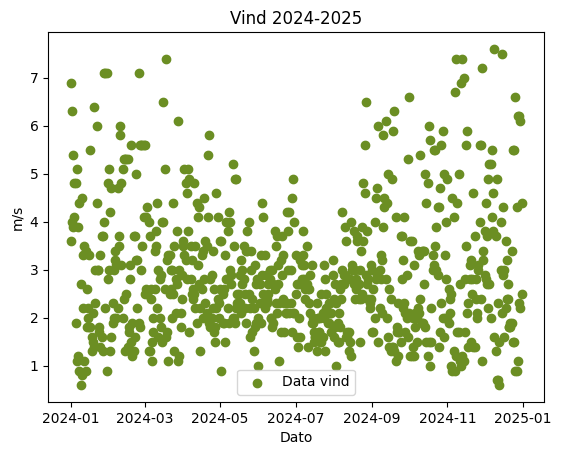

In [25]:
plt.scatter(clean_wind['referansetid'], clean_wind['verdi'], color = 'olivedrab', label = 'Data vind')

plt.xlabel('Dato')
plt.ylabel('m/s')
plt.title('Vind 2024-2025')
plt.legend()

I denne grafen kan vi se at det regner mest rundt februar og minst rundt juli, men dette kan visualiseres tydligere ved å definere månedende og finne måendtlig gjennomsnitt. 

In [26]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'Mai', 'Jun', 'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Des']

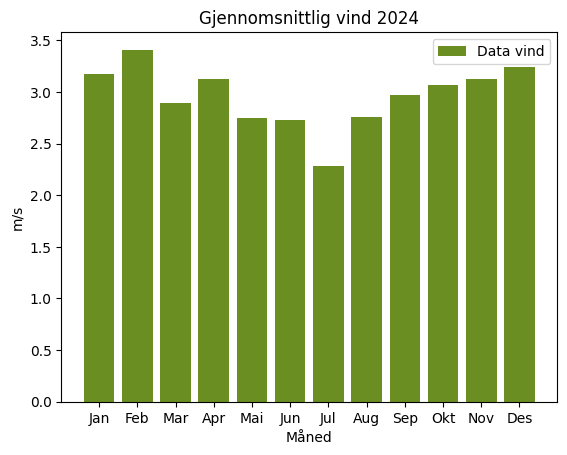

In [27]:
plt.bar(months, avg_moth, color = 'olivedrab', label = 'Data vind')

plt.xlabel('Måned')
plt.ylabel('m/s')
plt.title('Gjennomsnittlig vind 2024')
plt.legend()

Ved å finne gjennomsnittet av hver måned kan vi med sikkerhet si at det er mest vind i februar og minst vind i juli. 

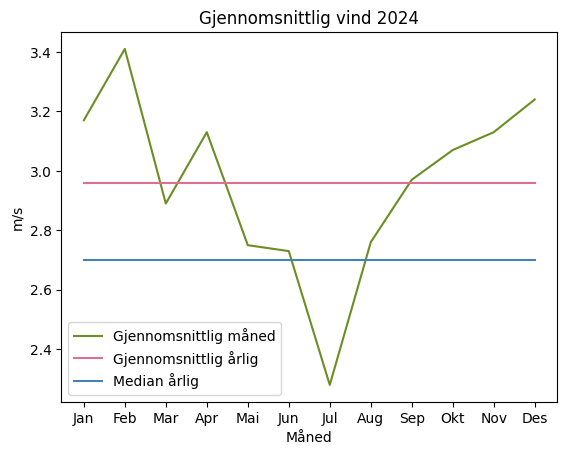

In [28]:
plt.plot(months, avg_moth, color = 'olivedrab', label = 'Gjennomsnittlig måned')
plt.plot(months, avg_year*np.ones(len(months)), color = 'palevioletred', label = 'Gjennomsnittlig årlig')
plt.plot(months, wind_median*np.ones(len(months)), color = 'steelblue', label = 'Median årlig')

plt.xlabel('Måned')
plt.ylabel('m/s')
plt.title('Gjennomsnittlig vind 2024')
plt.legend()

I denne grafen er det også lagt inn årlig gjennomsitt og medianen av vind. Da kan vi se at det er i mars, mai og september det blåser likest med det årlige gjennomsnittet. Det er i juli og august det er likest med medianen. 

In [29]:
fig = px.scatter(clean_wind, x='referansetid', y='verdi', color = 'verdi')
fig.update_layout(title = dict(text = 'Vind'))
fig.show()

I denne grafen blir det tydeliggjort at det er mest vind mellom 1 m/s og 3 m/s.

# Prediktiv analyse
Ved å se på vinddataen fra 2024 og 2025 kan vi anta hvordan vinden kommer til å endre seg i fremtiden. 

In [30]:
# Deler datasettet inn i train og test
X_train, X_test, y_train, y_test = fc.train_test_set(clean_wind, 0.3)    

referansetid har fått labels
     verdi tidsforskyvning  referansetid  måned
0      6.9            PT0H             0      1
1      6.3            PT0H             1      1
2      5.4            PT0H             2      1
3      4.8            PT0H             3      1
4      1.9            PT0H             4      1
..     ...             ...           ...    ...
727    4.3            PT0H           361     12
728    6.2            PT0H           362     12
729    6.2            PT0H           363     12
730    6.1            PT0H           364     12
731    4.4            PT0H           365     12

[732 rows x 4 columns]
Datasettet er delt inn i train og test
Størrelsen på test er 0.3


Nå har vi delt datasettet inn i train og test, og vi kan fortsette med å regne linærregresjon og andreregresjon.

### Linærregresjon

koeffisienter: -0.00013481942052364702
konstantledd: 3.0229413336635274


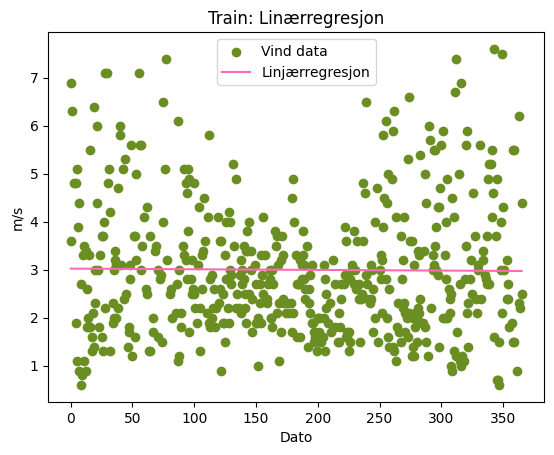

In [31]:
lin_pred = fc.linear(X_train, y_train)

# Lag et diagram med train verdier
plt.scatter(X_train, y_train, color = 'olivedrab', label = 'Vind data')
# Lag en linje med Linjærregesjon
plt.plot(X_train, lin_pred, color = 'hotpink', label = 'Linjærregresjon')

plt.xlabel('Dato')
plt.ylabel('m/s')
plt.title('Train: Linærregresjon')
plt.legend()

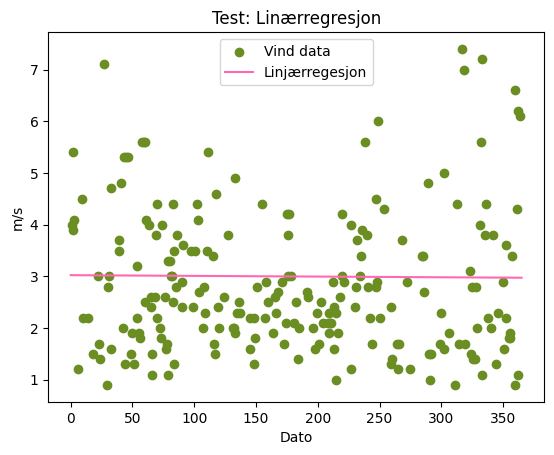

In [32]:
# Lag et diagram med test verdier
plt.scatter(X_test, y_test, color = 'olivedrab', label = 'Vind data')
# Lag en linje med Linjærregesjon
plt.plot(X_train, lin_pred, color = 'hotpink', label = 'Linjærregesjon')

plt.xlabel('Dato')
plt.ylabel('m/s')
plt.title('Test: Linærregresjon')
plt.legend()

### Andregradsregresjon

koeffisienter: -0.0084916294180914 2.3084324530644177e-05
konstantledd: 3.5245739056867462


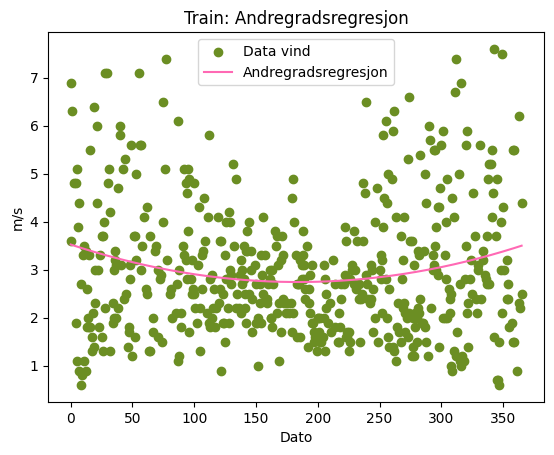

In [33]:
poly_pred = fc.poly(X_train, y_train)

# Lag et diagram med train verdier
plt.scatter(X_train, y_train, color = 'olivedrab', label = 'Data vind')
# Lag en linje med Andregradsregresjon
plt.plot(X_train, poly_pred, color = 'hotpink', label = 'Andregradsregresjon')

plt.xlabel('Dato')
plt.ylabel('m/s')
plt.title('Train: Andregradsregresjon')
plt.legend()

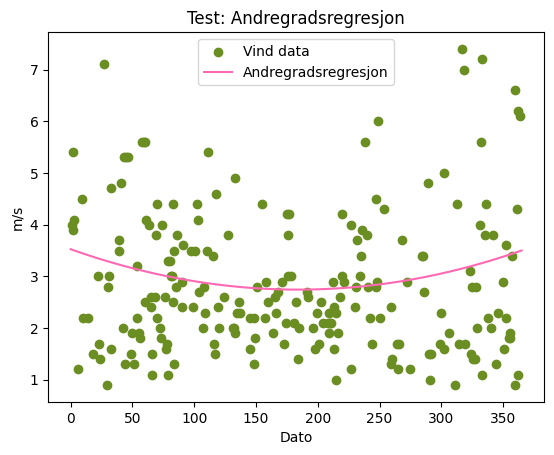

In [34]:
# Lag et diagram med test verdier
plt.scatter(X_test, y_test, color = 'olivedrab', label = 'Vind data')
# Lag en linje med Andregradsregresjon
plt.plot(X_train, poly_pred, color = 'hotpink', label = 'Andregradsregresjon')

plt.xlabel('Dato')
plt.ylabel('m/s')
plt.title('Test: Andregradsregresjon')
plt.legend()

In [35]:
# Print den kvadratiskegjennomsnittet
print(mean_squared_error(y_train, lin_pred))
print(mean_squared_error(y_train, poly_pred))

1.957920891670786
1.9049787919038694


Det er svært lite forskjell mellom den linæreregresjonen og andregradsregresjonen. Det kvadratiske gjennomsnittet viser at begge reggresjonene passer like bra. 